In [1]:
from datetime import datetime
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

def get_rmse_by_class(df, target_var):
    squared_error = df_predicted[
        lambda x: x.actual == 1
    ].apply(lambda x: np.square(x[target_var] - x.actual), axis=1)
    n_items = squared_error.shape[0]
    mean_squared_error = np.sum(squared_error) / n_items
    rmse_class_true = np.sqrt(mean_squared_error)
    
    squared_error = df_predicted[
        lambda x: x.actual == 0
    ].apply(lambda x: np.square(x[target_var] - x.actual), axis=1)
    n_items = squared_error.shape[0]
    mean_squared_error = np.sum(squared_error) / n_items
    rmse_class_false = np.sqrt(mean_squared_error)
    
    squared_error = df_predicted.apply(lambda x: np.square(x[target_var] - x.actual), axis=1)
    n_items = squared_error.shape[0]
    mean_squared_error = np.sum(squared_error) / n_items
    rmse = np.sqrt(mean_squared_error)
    
    return rmse_class_false, rmse_class_true, rmse

def print_model_performance(df, produce_confusion_mat=True, target_var='probability'):
    rmse_class_false, rmse_class_true, rmse = get_rmse_by_class(df, target_var)
    print(f'RMSE (Positives): {rmse_class_true:.4f}')
    print(f'RMSE (Negatives): {rmse_class_false:.4f}')
    print(f'RMSE: {rmse:.4f}')
    
    fpr, tpr, thresholds = metrics.roc_curve(
        df_predicted.actual,
        df_predicted.probability if target_var == 'probability' else df_predicted.predicted
    )
    auc = metrics.auc(fpr, tpr)
    print(f'AUC: {auc:.4f}\n')
    
    if produce_confusion_mat:
        n_fp = df_predicted[lambda x: (x.actual == 0) & (x.predicted == 1)].shape[0]
        n_fn = df_predicted[lambda x: (x.actual == 1) & (x.predicted == 0)].shape[0]
        n_tp = df_predicted[lambda x: (x.actual == 1) & (x.predicted == 1)].shape[0]
        n_tn = df_predicted[lambda x: (x.actual == 0) & (x.predicted == 0)].shape[0]

        confusion_matrix = np.array([
            [n_tp, n_fp],
            [n_fn, n_tn]
        ])

        weighted_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=0)

        print(f'Confusion Matrix\n{confusion_matrix}\n')
        print(f'Weighted Confusion Matrix\n{weighted_confusion_matrix}\n')

def get_birthplace_country(x):
    country = x.split(' ')[-1]
    return country

def get_feature_importance(cols, arr_feature_importances, min_importance_threshold=1):
    feature_importances = {
        col: arr_feature_importances[ix] \
        for ix, col in enumerate(cols) if arr_feature_importances[ix] > min_importance_threshold
    }
    
    return feature_importances

TARGET_COVID = 'target_covid'
TARGET_COVID_DEATH = 'target_covid_death'
TARGET_COVID_VENTILATED = 'target_covid_ventilated'
TARGET_N_DAYS_HOSPITALIZED = 'target_n_days_hospitalized'
TARGET_N_DAYS_ICU = 'target_n_days_icu'
TARGET_HOSPITALIZED_STATUS = 'target_hospitalized_status'
TARGET_ICU_STATUS = 'target_icu_status'

PREDICTED_COVID_DEATH = 'predicted_covid_death'

TARGET_VARIABLE_COVID_POSITIVE = 1
TARGET_VARIABLE_COVID_NEGATIVE = 0
TARGET_VARIABLE_COVID_DEAD = 1
TARGET_VARIABLE_COVID_SURVIVED = 0
TARGET_VARIABLE_COVID_VENTILATED = 1
TARGET_VARIABLE_COVID_NOT_VENTILATED = 0
TARGET_VARIABLE_HOSPITALIZED_STATUS_POSITIVE = 1
TARGET_VARIABLE_HOSPITALIZED_STATUS_NEGATIVE = 0
TARGET_VARIABLE_ICU_STATUS_POSITIVE = 1
TARGET_VARIABLE_ICU_STATUS_NEGATIVE = 0

CODE_ENCOUNTER_ICU_COVID = 305351004
CODE_ENCOUNTER_HOSPITALIZED_COVID = 1505002
CODE_PROCEDURE_VENTILATOR = 26763009
CODE_PROCEDURE_SUSPECTED_COVID = 261352009
CODE_CONDITION_COVID_POSITIVE = 840539006
CODE_OBSERVATION_COVID = '94531-1'
VALUE_OBSERVATION_COVID_NEGATIVE = 'Not detected (qualifier value)'
VALUE_OBSERVATION_COVID_POSITIVE = 'Detected (qualifier value)'
REASON_DESCRIPTION_PROCEDURE_COVID19 = 'COVID-19'
REASON_DESCRIPTION_PROCEDURE_SUSPECTED_COVID19 = 'Suspected COVID-19'
REASON_DESCRIPTION_CAREPLAN_COVID19 = 'COVID-19'
REASON_DESCRIPTION_CAREPLAN_SUSPECTED_COVID19 = 'Suspected COVID-19'

HAD_COVID_TEST = 'had_covid_test'
STATUS_HAD_COVID_TEST = 1
STATUS_NO_COVID_TEST = 0

N_DAYS_RECENT_CONDITION_THRESHOLD = 270
N_DAYS_RECENT_PROCEDURE_THRESHOLD = 270
N_DAYS_RECENT_ENCOUNTER_THRESHOLD = 270
N_DAYS_RECENT_CAREPLAN_THRESHOLD = 180
N_DAYS_RECENT_MEDICATION_THRESHOLD = 180

df_patients = pd.read_csv('data\\train\\patients.csv')
df_observations = pd.read_csv('data\\train\\observations.csv')
df_conditions = pd.read_csv('data\\train\\conditions.csv')
df_procedures = pd.read_csv('data\\train\\procedures.csv')
df_encounters = pd.read_csv('data\\train\\encounters.csv') 
df_careplans = pd.read_csv('data\\train\\careplans.csv')
df_devices = pd.read_csv('data\\train\\devices.csv')
df_medications = pd.read_csv('data\\train\\medications.csv')
df_supplies = pd.read_csv('data\\train\\supplies.csv')
df_allergies = pd.read_csv('data\\train\\allergies.csv')

df_patients_test = pd.read_csv('data\\test\\patients.csv')
df_encounters_test = pd.read_csv('data\\test\\encounters.csv')
df_careplans_test = pd.read_csv('data\\test\\careplans.csv') 
df_conditions_test = pd.read_csv('data\\test\\conditions.csv')
df_observations_test = pd.read_csv('data\\test\\observations.csv')
df_medications_test = pd.read_csv('data\\test\\medications.csv')
df_procedures_test = pd.read_csv('data\\test\\procedures.csv')
df_devices_test = pd.read_csv('data\\test\\devices.csv')

df_observations_test['DATE'] = pd.to_datetime(df_observations_test.DATE)
df_conditions_test['START'] = pd.to_datetime(df_conditions_test.START)
df_conditions_test['STOP'] = pd.to_datetime(df_conditions_test.STOP)
df_procedures_test['DATE'] = pd.to_datetime(df_procedures_test.DATE)
df_encounters_test['START'] = pd.to_datetime(df_encounters_test.START)
df_encounters_test['STOP'] = pd.to_datetime(df_encounters_test.STOP)
df_medications_test['START'] = pd.to_datetime(df_medications_test.START)
df_medications_test['STOP'] = pd.to_datetime(df_medications_test.STOP)
df_devices_test['START'] = pd.to_datetime(df_devices_test.START)
df_devices_test['STOP'] = pd.to_datetime(df_devices_test.STOP)

df_observations['DATE'] = pd.to_datetime(df_observations.DATE)
df_supplies['DATE'] = pd.to_datetime(df_supplies.DATE)
df_procedures['DATE'] = pd.to_datetime(df_procedures.DATE)
df_conditions['START'] = pd.to_datetime(df_conditions.START)
df_conditions['STOP'] = pd.to_datetime(dbf_conditions.STOP)
df_encounters['START'] = pd.to_datetime(df_encounters.START)
df_encounters['STOP'] = pd.to_datetime(df_encounters.STOP)
df_careplans['START'] = pd.to_datetime(df_careplans.START)
df_careplans['STOP'] = pd.to_datetime(df_careplans.STOP)
df_medications['START'] = pd.to_datetime(df_medications.START)
df_medications['STOP'] = pd.to_datetime(df_medications.STOP)
df_devices['START'] = pd.to_datetime(df_devices.START)
df_devices['STOP'] = pd.to_datetime(df_devices.STOP)
df_allergies['START'] = pd.to_datetime(df_allergies.START)
df_allergies['STOP'] = pd.to_datetime(df_allergies.STOP)

# Feature Engineering

In [7]:
#
# Build training data set that includes patients that tested both negative and positive
#
ids_patients_covid_positive = df_observations[
    lambda x: (
        (x.CODE == CODE_OBSERVATION_COVID) & \
        (x.VALUE == VALUE_OBSERVATION_COVID_POSITIVE)
    )
].PATIENT.unique()
ids_patients_covid_negative = df_observations[
    lambda x: (
        (x.CODE == CODE_OBSERVATION_COVID) & \
        (x.VALUE == VALUE_OBSERVATION_COVID_NEGATIVE) & \
        ~(x.PATIENT.isin(ids_patients_covid_positive))
    )
].PATIENT.unique()
ids_patients_covid_tested = pd.concat([
    pd.Series(ids_patients_covid_positive), 
    pd.Series(ids_patients_covid_negative)
])

# Assume untested patients don't have COVID so we can train on more data 
# Severe class imbalance issues for those who never tested positive
ids_patients_covid_untested = df_patients[
    lambda x: ~x.Id.isin(ids_patients_covid_tested)
].PATIENT.unique()

# Patient can have multiple encountrs, each encounter can have a multiple reason codes on different dates
ids_patients_ventilated = df_procedures[lambda x: x.CODE == CODE_PROCEDURE_VENTILATOR]
df_ventilated = ids_patients_ventilated[[
    'PATIENT'
]].drop_duplicates(
).reset_index(
    drop=True
).rename(columns={
    'PATIENT': 'id'
})
df_ventilated[TARGET_COVID_VENTILATED] = TARGET_VARIABLE_COVID_VENTILATED

print(f'{ids_patients_covid_positive.shape[0]:,} tested positive out of ' \
      f'{ids_patients_covid_tested.shape[0]:,} patients')

# For features that represent an event with a timestamp, ensure the event occurs before or on the
# day of the test. We first must get the earliest test date.
df_earliest_test = df_observations[
    lambda x: (x.CODE == CODE_OBSERVATION_COVID)
].groupby('PATIENT')[['DATE']].min().reset_index().rename(columns={
    'PATIENT': 'id',
    'DATE': 'earliest_test_date'
})

# Exclude observations from COVID tests in training data that aren't also available in the testing data
df_observations_cols_covid_train_test = df_earliest_test.merge(
    df_observations.rename(columns={
        'PATIENT': 'id',
        'DATE': 'earliest_test_date'
    }),
    how='inner',
    on=['id','earliest_test_date']
).groupby('DESCRIPTION').count(
).sort_values(
    'id', 
    ascending=False
).reset_index(
).iloc[:, :3].rename(columns={
    'id':'TRAINING_COUNT'
}).merge(
    df_observations_test.groupby('DESCRIPTION').count(
    ).reset_index(
    ).iloc[:, :3].rename(columns={
        'DATE':'TESTING_COUNT'
    }),
    on='DESCRIPTION',
    how='left'
)

# Also, get hosptilization and ICU durations for each patient, if any
df_encounter_hospitalized_covid = df_encounters[
    lambda x: (x.CODE == CODE_ENCOUNTER_HOSPITALIZED_COVID)
].rename(columns={
    'PATIENT': 'id'
})[[
    'id',
    'START',
    'STOP'
]]
df_encounter_hospitalized_covid[TARGET_N_DAYS_HOSPITALIZED] = (
    df_encounter_hospitalized_covid.STOP - df_encounter_hospitalized_covid.START
).astype('timedelta64[h]') / 24

df_encounter_hospitalized_covid = df_encounter_hospitalized_covid.rename(columns={
    'START': 'hospitalized_start',
    'STOP': 'hospitalized_end',
})

# Also, get ICU durations
df_encounter_icu_covid = df_encounters[
    lambda x: (x.CODE == CODE_ENCOUNTER_ICU_COVID)
].rename(columns={
    'PATIENT': 'id'
})[[
    'id',
    'START',
    'STOP'
]]
df_encounter_icu_covid[TARGET_N_DAYS_ICU] = (
    df_encounter_icu_covid.STOP - df_encounter_icu_covid.START
).astype('timedelta64[h]') / 24

df_encounter_icu_covid = df_encounter_icu_covid.rename(columns={
    'START': 'icu_start',
    'STOP': 'icu_end',
})

# # Get list of columns common in both training/testing observations data set 
# cols_observations_covid_frequent = df_observations_test[
#     lambda x: (x.DESCRIPTION.isin(cols_observation_test)) & (x.TYPE == 'numeric')
# ].groupby(['PATIENT','DESCRIPTION']).count().sort_values('DATE', ascending=False).reset_index()[
#     lambda x: x.DATE > 3 # >4 and <= 8: 52 unique observations
# ].DESCRIPTION.unique()

# df_observations_during_test = df_earliest_test.merge(
#     df_observations[
#         lambda x: x.DESCRIPTION.isin(cols_observations_covid_frequent)
#     ].rename(columns={
#         'PATIENT': 'id',
#     }),
#     how='inner',
#     on='id'
# )[
#     lambda x: x.DATE >= x.earliest_test_date
# ]

# df_observations_during_test_agg = df_observations_during_test.groupby('id').agg(
#     date_min = pd.NamedAgg('DATE', 'min'),
#     date_max = pd.NamedAgg('DATE', 'max'),
# #     n_tests = pd.NamedAgg('DATE', 'distinct')
# ).reset_index()

# df_observations_during_test_agg['duration'] = (
#     df_observations_during_test_agg['date_max'] - \
#     df_observations_during_test_agg['date_min']
# ).astype('timedelta64[D]')

# df_observations_during_test_with_minmax = df_observations_during_test_agg.merge(
#     df_observations_during_test,
#     on='id',
#     how='inner'
# )

# cols_observations_covid_frequent_no_diff = []
# for col in cols_observations_covid_frequent:
#     df_ = df_observations_during_test_with_minmax[
#         lambda x: (x.DATE == x.date_min) & (x.date_min != x.date_max) & (x.DESCRIPTION == col)
#     ].rename(columns={
#         'VALUE': 'value_at_date_min'
#     }).merge(
#         df_observations_during_test_with_minmax[
#             lambda x: (x.DATE == x.date_max) & (x.date_min != x.date_max) & (x.DESCRIPTION == col)
#         ].rename(columns={
#             'VALUE': 'value_at_date_max'
#         }),#.VALUE.astype(float)
#         on='id',
#         how='left'
#     )
    
#     delta = (df_.value_at_date_max.astype(float) - df_.value_at_date_min.astype(float))[lambda x: (~pd.isnull(x)) & (x > 0)]
#     if delta.shape[0] == 0:
#         cols_observations_covid_frequent_no_diff.append(col)

cols_observations_covid_frequent = [
    'Diastolic Blood Pressure', 'Systolic Blood Pressure',
    'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
    'Weight difference [Mass difference] --pre dialysis - post dialysis',
    'Sodium', 'Urea Nitrogen', 'Chloride', 'Potassium',
    'Carbon Dioxide', 'Glucose', 'Creatinine', 'Calcium',
    'Glucose [Mass/volume] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip',
    'pH of Urine by Test strip',
    'Protein [Mass/volume] in Serum or Plasma',
    'Protein [Mass/volume] in Urine by Test strip',
    'Specific gravity of Urine by Test strip',
    'Glomerular filtration rate/1.73 sq M.predicted',
    'Mental health Outpatient Note',
    'Globulin [Mass/volume] in Serum by calculation',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Urine by Test strip',
    'Mental health Telehealth Note',
    'Low Density Lipoprotein Cholesterol',
    'High Density Lipoprotein Cholesterol', 'Triglycerides',
    'Total Cholesterol',
    'Platelets [#/volume] in Blood by Automated count',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Erythrocyte distribution width [Entitic volume] by Automated count',
    'Leukocytes [#/volume] in Blood by Automated count',
    'MCH [Entitic mass] by Automated count',
    'MCHC [Mass/volume] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Platelet distribution width [Entitic volume] in Blood by Automated count',
    'Platelet mean volume [Entitic volume] in Blood by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Respiratory rate', 'Microalbumin Creatinine Ratio', 'Body Height',
    'Heart rate', 'Body Mass Index', 'Body Weight',
    'Estimated Glomerular Filtration Rate',
    'Hemoglobin A1c/Hemoglobin.total in Blood', 'FEV1/FVC',
    'History of Hospitalizations+Outpatient visits',
    'Oxygen saturation in Arterial blood'
]

# Finally, before we proceed with any further feature engineering, transactional patient data will 
# be filtered out relative to the earliest COVID test date for training data, and for testing data we
# will filter out based on the last recorded date amongst all data sets with a date column for testing
# data.
df_testing_patient_last_date = df_observations_test.groupby([
    'PATIENT'
])['DATE'].last(
).reset_index(
).rename(columns={
    'DATE': 'observation_date_last'
}).merge(
    df_conditions_test.groupby([
        'PATIENT'
    ])['STOP'].last(
    ).reset_index(
    ).rename(columns={
        'STOP': 'condition_date_last'
    })
).merge(
    df_procedures_test.groupby([
        'PATIENT'
    ])['DATE'].last(
    ).reset_index(
    ).rename(columns={
        'DATE': 'procedure_date_last'
    })
).merge(
    df_encounters_test.groupby([
        'PATIENT'
    ])['STOP'].last(
    ).reset_index(
    ).rename(columns={
        'STOP': 'encounter_date_last'
    })
).merge(
    df_medications_test.groupby([
        'PATIENT'
    ])['STOP'].last(
    ).reset_index(
    ).rename(columns={
        'STOP': 'medication_date_last'
    })
)
df_testing_patient_last_date['encounter_date_last'] = df_testing_patient_last_date['encounter_date_last'].astype('datetime64[ns]')
df_testing_patient_last_date['date_last'] = np.max([
    df_testing_patient_last_date.observation_date_last.fillna(pd.to_datetime('1900-01-01')), 
    df_testing_patient_last_date.condition_date_last.fillna(pd.to_datetime('1900-01-01')), 
    df_testing_patient_last_date.procedure_date_last.fillna(pd.to_datetime('1900-01-01')), 
    df_testing_patient_last_date.encounter_date_last.fillna(pd.to_datetime('1900-01-01')),
    df_testing_patient_last_date.medication_date_last.fillna(pd.to_datetime('1900-01-01')),
], axis=0)
df_testing_patient_last_date = df_testing_patient_last_date[[
    'PATIENT',
    'date_last'
]]

73,697 tested positive out of 75,417 patients


array(['8c6f61a6-1beb-4b51-980e-381722ca7e33',
       '6732e6fc-f8f3-4b1a-924a-47f68f19526c',
       '4772a573-1fb1-49ec-be86-dc2c4b176052', ...,
       '80c8ab65-5f76-40cf-bbfa-4c42807b21a2',
       'b2eb252e-fb3d-4f45-aeb7-dcfa5fa90057',
       '40f3b714-8f77-472a-8b26-eae6eca14106'], dtype=object)

In [337]:
# Merge testing + training patient data
df_patients_test['is_testing_data'] = 0
df_patients['is_testing_data'] = 1
df_patients = pd.concat([
    df_patients,
    df_patients_test
])

# Label those who have died
df_patients['ind_dead'] = 0
df_patients.loc[
    lambda x: ~pd.isnull(x.DEATHDATE),
    'ind_dead'
] = 1

# Demographic feature: Born in US or not. More than 90% of patients are US-born so we'll lump the
#                      other birth countries together.
df_patients['BIRTH_COUNTRY'] = df_patients.apply(lambda x: get_birthplace_country(x.BIRTHPLACE), axis=1)
df_patients['demographic_birth_country_us'] = 0
df_patients.loc[
    lambda x: x.BIRTH_COUNTRY == 'US',
    'demographic_birth_country_us'
] = 1

# Demographic feature: Age, extracted from date of birth
df_patients['BIRTHDATE'] = pd.to_datetime(df_patients['BIRTHDATE'])
df_patients['demographic_age'] = (
    # Delta in seconds, converted to years. I'm sure there's a more elegant way
    (datetime.now() - df_patients.BIRTHDATE).astype('timedelta64[D]') / 365
)

# Demographic feature: Marital status. Plausible that more people in a household increases risk 
#                      exposure to COVID
df_patients['demographic_married'] = 0
df_patients.loc[
    lambda x: x.MARITAL == 'M',
    'demographic_married'
] = 1

# Demographic feature: County. In case there is between-county COVID risk variance
df_patients['demographic_county_residence'] = df_patients.COUNTY

# Demographic feature: Race.
df_patients['demographic_race'] = df_patients.RACE

# Demographic feature: Gender.
df_patients['demographic_gender'] = df_patients.GENDER

# Demographic feature: Possession of passport.
df_patients['demographic_has_passport'] = 0
df_patients.loc[
    lambda x: ~pd.isnull(x.PASSPORT),
    'demographic_has_passport'
] = 1

# Demographic feature: Possession of a driving license.
df_patients['demographic_has_driving_license'] = 0
df_patients.loc[
    lambda x: ~pd.isnull(x.DRIVERS),
    'demographic_has_driving_license'
] = 1

# Demographic feature: Dollar amount of healthcare coverage.
df_patients['demographic_healthcare_coverage'] = df_patients.HEALTHCARE_COVERAGE

# Demographic feature: Dollar amount of healthcare expenses.
df_patients['demographic_healthcare_expenses'] = df_patients.HEALTHCARE_EXPENSES

# Observations feature: Last set of observations during first COVID test
df_last_observations_during_test = pd.concat([
    df_observations[
        lambda x: x.DESCRIPTION.isin(cols_observations_covid_frequent)
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test.rename(columns={
            'earliest_test_date': 'DATE'
        }),
        on=['id','DATE'],
        how='inner'
    ),
    # Merge with testing data.
    # For observations in the testing data set, use the last date as we don't have a COVID test date
    df_observations_test[
        lambda x: x.DESCRIPTION.isin(cols_observations_covid_frequent)
    ].groupby([
        'PATIENT',
        'DESCRIPTION',
        'DATE'
    ]).last().reset_index().rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='VALUE',
    aggfunc='last'
).reset_index()[['id'] + list(cols_observations_covid_frequent)]

df_last_observations_during_test = df_last_observations_during_test.rename(columns={
    col:f'observation_{col}' for col in df_last_observations_during_test.columns[1:] # Skip first ID column
}, errors='raise')

# Condition feature: Chronic conditions 
df_conditions_chronic_pivot = pd.concat([
    df_conditions[
        lambda x: x.DESCRIPTION.isin(df_conditions_test.DESCRIPTION.unique())
    ].rename(columns={
        'PATIENT': 'id'
    })[
        # Include only conditions without a stop date (chronic)
        lambda x: pd.isnull(x.STOP)
    ].merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure conditions were diagnosed before any COVID testing
        lambda x: (x.START < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge with testing data
    df_conditions_test.rename(columns={
        'PATIENT': 'id'
    })[
        # Include only conditions without a stop date (chronic)
        lambda x: pd.isnull(x.STOP)
    ]
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='START',
    aggfunc='count'
).fillna(0).reset_index()

df_conditions_chronic_pivot = df_conditions_chronic_pivot.rename(columns={
    col:f'condition_chronic_{col}' for col in df_conditions_chronic_pivot.columns[1:] # Skip first ID column
}, errors='raise')

# Condition feature: Recent conditions in the past N days
df_conditions_recent_pivot = pd.concat([
    df_conditions[
        lambda x: (
            ((datetime.now() - x.STOP).astype('timedelta64[D]') <= N_DAYS_RECENT_CONDITION_THRESHOLD) & \
            (x.DESCRIPTION.isin(df_conditions_test.DESCRIPTION.unique()))
        )
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure recent conditions have happened before any COVID testing
        lambda x: (x.START < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge testing data
    df_conditions_test.merge(
        df_testing_patient_last_date,
        how='inner',
        on='PATIENT'
    )[
        lambda x: (x.date_last - x.STOP).astype('timedelta64[D]') <= N_DAYS_RECENT_CONDITION_THRESHOLD
    ].rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='STOP',
    aggfunc='count'
).fillna(0).reset_index()

df_conditions_recent_pivot = df_conditions_recent_pivot.rename(columns={
    col:f'condition_recent_{col}' for col in df_conditions_recent_pivot.columns[1:] # Skip first ID column
}, errors='raise')

# Procedure feature: Recent procedures in the past N days
df_procedures_non_ventilator = pd.concat([
    df_procedures[
        lambda x: (
            ~(x.CODE.isin([CODE_PROCEDURE_VENTILATOR, CODE_PROCEDURE_SUSPECTED_COVID])) & 
            (x.PATIENT.isin(ids_patients_covid_tested)) & # Only consider other procedures on tested patients
            ((datetime.now() - x.DATE).astype('timedelta64[D]') <= N_DAYS_RECENT_PROCEDURE_THRESHOLD) & 
            ~(x.REASONDESCRIPTION.isin([REASON_DESCRIPTION_PROCEDURE_COVID19, REASON_DESCRIPTION_PROCEDURE_SUSPECTED_COVID19])) & # This wont be in the testing data set 
            (x.DESCRIPTION.isin(df_procedures_test.DESCRIPTION.unique()))
        )
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure procedures have happened before any COVID testing
        lambda x: (x.DATE < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge with testing data
    df_procedures_test.merge(
        df_testing_patient_last_date,
        how='inner',
        on='PATIENT'
    )[
        lambda x: (x.date_last - x.DATE).astype('timedelta64[D]') <= N_DAYS_RECENT_PROCEDURE_THRESHOLD
    ].rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='DATE',
    aggfunc='count'
)

df_procedures_non_ventilator = df_procedures_non_ventilator.rename(columns={
    col:f'procedures_{col}' for col in df_procedures_non_ventilator.columns[1:] # Skip first ID column
}, errors='raise')

# Allergies feature: Assumed permanent, so no recency filters. Also treated as encounters so we'll filter
#                    out any allergy-related encounters from the encounters data set.
#                    UPDATE: Removing from dataset. No performance gain.
ids_allergy_related_encounter = df_allergies.ENCOUNTER
# df_allergy = df_allergies.rename(columns={
#     'PATIENT': 'id'
# }).merge(
#     df_encounter_hospitalized_covid,
#     on='id',
#     how='left'
# )[
#     # Ensure encounters have happened before any COVID testing
#     lambda x: (x.START < x.hospitalized_start.astype('datetime64[ns]')) | pd.isnull(x.hospitalized_start)
# ].pivot_table(
#     index='id',
#     columns='DESCRIPTION',
#     values='STOP',
#     aggfunc='count'
# ).fillna(0).reset_index()

# df_allergy = df_allergy.rename(columns={
#     col:f'allergy_{col}' for col in df_allergy.columns[1:] # Skip first ID column
# }, errors='raise')

# Encounters feature: Recent encounters in the past N days
df_encounters_recent = pd.concat([
    df_encounters[
        lambda x: x.DESCRIPTION.isin(df_encounters_test.DESCRIPTION.unique())
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        lambda x: (
            # Ensure encounters have happened before any COVID testing
            (x.START.astype('datetime64[ns]') < x.earliest_test_date) | pd.isnull(x.earliest_test_date) & \
            # Exclude allergy-related encounters, already handled
            ~(x.Id.isin(ids_allergy_related_encounter))
        )
    ][
        lambda x: (
            (x.id.isin(ids_patients_covid_tested)) & \
            ((datetime.utcnow() - \
              x.STOP.astype('datetime64[ns]')).astype('timedelta64[D]') <= N_DAYS_RECENT_ENCOUNTER_THRESHOLD)
        )
    ],
    # Merge with testing data
    df_encounters_test.merge(
        df_testing_patient_last_date,
        how='inner',
        on='PATIENT'
    )[
        lambda x: (x.date_last - x.STOP.astype('datetime64[ns]')).astype('timedelta64[D]') <= 30
    ].rename(columns={
        'PATIENT': 'id'
    })[
        lambda x: ~(x.Id.isin(ids_allergy_related_encounter))
    ]
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='STOP',
    aggfunc='count'
).fillna(0).reset_index() # 64,983 rows after merge vs 4,221

df_encounters_recent = df_encounters_recent.rename(columns={
    col:f'encounters_{col}' for col in df_encounters_recent.columns[1:] # Skip first ID column
}, errors='raise')

# Care Plan feature: Recent careplans in the past N days, including those without an end-date
df_careplans_recent = pd.concat([
    df_careplans[
        lambda x: x.DESCRIPTION.isin(df_careplans_test.DESCRIPTION.unique())
    ][
        lambda x: (((datetime.now() - x.STOP).astype('timedelta64[D]') <= N_DAYS_RECENT_CAREPLAN_THRESHOLD) & \
            ~(x.REASONDESCRIPTION.isin([ 
                # These won't be in the testing data 
                REASON_DESCRIPTION_CAREPLAN_COVID19,
                REASON_DESCRIPTION_CAREPLAN_SUSPECTED_COVID19
            ]))
        )
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure recent conditions have happened before any COVID testing
        lambda x: (x.START < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge with testing data
    df_careplans_test.merge(
        df_testing_patient_last_date,
        how='inner',
        on='PATIENT'
    )[
        lambda x: (x.date_last - x.STOP.astype('datetime64[ns]')).astype('timedelta64[D]') <= N_DAYS_RECENT_CAREPLAN_THRESHOLD
    ].rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='STOP',
    aggfunc='count'
).fillna(0).reset_index()

df_careplans_recent = df_careplans_recent.rename(columns={
    col:f'careplans_{col}' for col in df_careplans_recent.columns[1:] # Skip first ID column
}, errors='raise')

# Medication feature: Chronic use or recent use of medication
df_medications_recent = pd.concat([
    df_medications[
        lambda x: (
            (
                pd.isnull(x.STOP) | \
                ((datetime.now() - x.STOP).astype('timedelta64[D]') <= N_DAYS_RECENT_MEDICATION_THRESHOLD)
            ) & (x.DESCRIPTION.isin(df_medications_test.DESCRIPTION.unique()))
        )
    ].rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure encounters have happened before any COVID testing
        lambda x: (x.START < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge testing data
    df_medications_test.merge(
        df_testing_patient_last_date,
        how='inner',
        on='PATIENT'
    )[
        lambda x: (
            ((x.date_last - x.STOP.astype('datetime64[ns]')).astype('timedelta64[D]') <= 60) | \
            (pd.isnull(x.STOP))
        )
    ].rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='START',
    aggfunc='count'
).fillna(0).reset_index()

df_medications_recent = df_medications_recent.rename(columns={
    col:f'medication_{col}' for col in df_medications_recent.columns[1:] # Skip first ID column
}, errors='raise')

# Devices feature: Installed devices (of 3, aretery stent/pacemaker/defibrilator)
# Note, we do not filter for only recent device installations. Device installations are assumed to 
# be permanent.
df_devices_installed = pd.concat([
    df_devices.rename(columns={
        'PATIENT': 'id'
    }).merge(
        df_earliest_test,
        on='id',
        how='left'
    )[
        # Ensure encounters have happened before any COVID testing
        lambda x: (x.START < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
    ],
    # Merge with testing data
    df_devices_test.rename(columns={
        'PATIENT': 'id'
    })
]).pivot_table(
    index='id',
    columns='DESCRIPTION',
    values='START',
    aggfunc='count'
).fillna(0).reset_index()

df_devices_installed = df_devices_installed.rename(columns={
    col:f'devices_{col}' for col in df_devices_installed.columns[1:] # Skip first ID column
}, errors='raise')

# # Supplies feature: Supplies used during encounter
# df_supplies_recent = df_supplies[
#     lambda x: ((datetime.now() - x.DATE).astype('timedelta64[D]') <= N_DAYS_RECENT_ENCOUNTER_THRESHOLD)
# ].rename(columns={
#     'PATIENT': 'id'
# }).merge(
#     df_earliest_test,
#     on='id',
#     how='left'
# )[
#     # Ensure encounters have happened before any COVID testing
#     lambda x: (x.DATE < x.earliest_test_date.astype('datetime64[ns]')) | pd.isnull(x.earliest_test_date)
# ].pivot_table(
#     index='id',
#     columns='DESCRIPTION',
#     values='DATE',
#     aggfunc='count'
# ).fillna(0).reset_index()

# df_supplies_recent = df_supplies_recent.rename(columns={
#     col:f'supplies_{col}' for col in df_supplies_recent.columns[1:] # Skip first ID column
# }, errors='raise')

C:\Users\bduyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\bduyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\bduyp\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\b

# Prepare model input data

In [370]:
# List of features from above and convert columns to cateogrical where indicated
features_demographic = [
    'demographic_birth_country_us',
    'demographic_county_residence', 
    'demographic_married',
    'demographic_age',
    'demographic_race',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'demographic_healthcare_expenses', 
    'demographic_has_driving_license', # No performance change
    'demographic_has_passport' # No performance change
]

features_model_covid = features_demographic \
  + list(df_conditions_chronic_pivot.columns)[1:] \
  + list(df_conditions_recent_pivot.columns)[1:] \
  + list(df_procedures_non_ventilator.columns)[1:] \
  + list(df_encounters_recent.columns)[1:] \
  + list(df_medications_recent.columns)[1:] \
  + list(df_devices_installed.columns)[1:] \
  + list(df_last_observations_during_test.columns)[1:] \
  + list(df_careplans_recent.columns)[1:] # Leave out first ID columns

features_model_covid_categorical = [
    'demographic_married',
    'demographic_birth_country_us',
    'demographic_county_residence',
    'demographic_race',
    'demographic_gender',
    'demographic_healthcare_expenses',
    'demographic_has_driving_license',
    'demographic_has_passport',
]

# Merge features from multiple data sets to create model input data
df_input_model = pd.concat([
    pd.DataFrame({
        'id': ids_patients_covid_positive,
        HAD_COVID_TEST: STATUS_HAD_COVID_TEST,
        'target_covid': TARGET_VARIABLE_COVID_POSITIVE
    }),
    pd.DataFrame({
        'id': ids_patients_covid_negative,
        HAD_COVID_TEST: STATUS_HAD_COVID_TEST,
        'target_covid': TARGET_VARIABLE_COVID_NEGATIVE
    }),
#     # Add untested patients and assume they do not have COVID
#     pd.DataFrame({
#         'id': df_patients_test.Id.unique(),
#         HAD_COVID_TEST: STATUS_NO_COVID_TEST,
#         'target_covid': TARGET_VARIABLE_COVID_NEGATIVE
#     })
]).reset_index(drop=True)

df_input_model = df_input_model.merge(
    df_patients.rename(columns={
        'Id': 'id'
    }).merge(
        df_ventilated,
        on='id',
        how='left'
    ).merge(
        df_conditions_chronic_pivot,
        on='id',
        how='left'
    ).merge(
        df_conditions_recent_pivot,
        on='id',
        how='left'
    ).merge(
        df_procedures_non_ventilator, 
        on='id',
        how='left'
    ).merge(
        df_encounters_recent, 
        on='id',
        how='left'
    ).merge(
        df_careplans_recent, 
        on='id',
        how='left'
    ).merge(
        df_medications_recent, 
        on='id',
        how='left'
    ).merge(
        df_devices_installed, 
        on='id',
        how='left'
    ).merge(
        df_last_observations_during_test, 
        on='id',
        how='left'
    ).merge(
        df_encounter_hospitalized_covid, 
        on='id',
        how='left'
    ).merge(
        df_encounter_icu_covid, 
        on='id',
        how='left'
    )[
        [
            'id',
            'is_testing_data',
            'ind_dead', 
            TARGET_COVID_VENTILATED,
            TARGET_N_DAYS_HOSPITALIZED,
            TARGET_N_DAYS_ICU
        ] + features_model_covid
    ],
    on='id',
    how='inner'
).fillna(0)

# lightgbm trips on certain charactesr in the column names
df_input_model.columns = [col.replace('[','(').replace(']',')') for col in df_input_model.columns]
features_model_covid = [col.replace('[','(').replace(']',')') for col in features_model_covid]

# Prepare the target variables for the multiple models that will use this input data
df_input_model[TARGET_COVID_DEATH] = 0
df_input_model.loc[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x.ind_dead == 1)
    ),
    TARGET_COVID_DEATH
] = TARGET_VARIABLE_COVID_DEAD

# Convert categorical and numerical based columns from object-based types
for col in features_model_covid_categorical:
    df_input_model[col] = df_input_model[col].astype('category')
    
cols_observation = [
    col.replace('[','(').replace(']',')') 
    for col in df_last_observations_during_test.columns[1:]
]
for col in cols_observation:
    try:
        if col in df_input_model.columns:
            df_input_model[col] = df_input_model[col].astype('float')
    except ValueError as e:
        # Remove observations that don't have numerical values
        features_model_covid.remove(col)
        
display(df_input_model.head(3).T)
display(df_input_model.shape)
display(df_input_model.dtypes)

,0,1,2
id,afa2680f-7f73-46d9-b0cd-2cf3db49724b,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,90031c21-e8a4-416e-b60b-23e871ee62dc
had_covid_test,1,1,1
target_covid,1,1,1
is_testing_data,1,1,1
ind_dead,0,0,0
...,...,...,...
careplans_Skin condition care,0,0,0
careplans_Spinal cord injury rehabilitation,0,0,0
careplans_Urinary tract infection care,0,0,0
careplans_Wound care,0,0,0


(75417, 686)

id                                              object
had_covid_test                                   int64
target_covid                                     int64
is_testing_data                                  int64
ind_dead                                         int64
                                                ...   
careplans_Skin condition care                  float64
careplans_Spinal cord injury rehabilitation    float64
careplans_Urinary tract infection care         float64
careplans_Wound care                           float64
target_covid_death                               int64
Length: 686, dtype: object

In [557]:
# Export model input data set
df_input_model.to_csv('df_input_model.csv', index=False)

# Predictive Models

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

## COVID Test Result

### Model

In [150]:
df_input_model[TARGET_COVID].value_counts()

1    73697
0     1720
Name: target_covid, dtype: int64

In [305]:
# features_covid_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_covid.feature_importances_, 
#     min_importance_threshold=50
# ).keys())

features_covid_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_healthcare_coverage',
    'condition_chronic_Hypertension',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood'
]

df_oversampled = df_input_model[
    lambda x: x[TARGET_COVID] == 0
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
    df_oversampled
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: x[TARGET_COVID] == 1
    ].sample(int(n_rows_underrepresented*7.5), random_state=42),
    df_oversampled
], axis=0)

x_train_covid, x_test_covid, y_train_covid, y_test_covid = train_test_split(
    df_sampled[features_covid_truncated],
    df_sampled[TARGET_COVID],
    test_size=0.35,
    random_state=42
)

fit_params={
#     'early_stopping_rounds': 10, 
}

model_covid = lgb.LGBMClassifier()
model_covid.fit(
    x_train_covid, 
    y_train_covid, 
    eval_set=[(x_test_covid, y_test_covid)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'probability': model_covid.predict_proba(x_test_covid)[:, 1], 
    'predicted': model_covid.predict(x_test_covid),
    'actual': y_test_covid
})

print_model_performance(df_predicted)

[100]	valid_0's rmse: 0.348992	valid_0's binary_logloss: 0.359325
RMSE (Positives): 0.2894
RMSE (Negatives): 0.4681
RMSE: 0.3490
AUC: 0.9043

Confusion Matrix
[[4050  560]
 [ 494 1217]]

Weighted Confusion Matrix
[[0.89128521 0.31513787]
 [0.10871479 0.68486213]]



In [186]:
# With information leak

[100]	valid_0's rmse: 1.18043e-05	valid_0's binary_logloss: 2.87672e-06
RMSE (Positives): 0.0000
RMSE (Negatives): 0.0001
RMSE: 0.0000

Confusion Matrix
[[72219     0]
 [    0  1690]]

Weighted Confusion Matrix
[[1. 0.]
 [0. 1.]]



## Death

In [313]:
df_input_model[
    lambda x: (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
][TARGET_COVID_DEATH].value_counts()

0    68129
1     5568
Name: target_covid_death, dtype: int64

### Model

In [342]:
# features_death_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_death.feature_importances_, 
#     min_importance_threshold=7
# ).keys())

features_death_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_race',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Anemia (disorder)',
    'condition_chronic_Body mass index 30+ - obesity (finding)',
    'condition_chronic_Chronic congestive heart failure (disorder)',
    'condition_chronic_Hyperlipidemia',
    'condition_chronic_Hypertension',
    'condition_chronic_Metastasis from malignant tumor of prostate (disorder)',
    'condition_chronic_Osteoarthritis of knee',
    'condition_chronic_Osteoporosis (disorder)',
    'condition_chronic_Prediabetes',
    'procedures_Combined chemotherapy and radiation therapy (procedure)',
    'procedures_Electrical cardioversion',
    'procedures_Medication Reconciliation (procedure)',
    'encounters_Consultation for treatment',
    'encounters_Encounter for check up (procedure)',
    'encounters_Encounter for problem',
    'encounters_Encounter for symptom',
    'encounters_General examination of patient (procedure)',
    'encounters_Prenatal visit',
    'encounters_Urgent care clinic (procedure)',
    'medication_24 HR Donepezil hydrochloride 10 MG / Memantine hydrochloride 28 MG Extended Release Oral Capsule',
    'medication_24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'medication_24 HR metoprolol succinate 100 MG Extended Release Oral Tablet (Toprol)',
    'medication_60 ACTUAT Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT Dry Powder Inhaler',
    'medication_FLUoxetine 20 MG Oral Capsule',
    'medication_Hydrochlorothiazide 25 MG Oral Tablet',
    'medication_Hydrocortisone 10 MG/ML Topical Cream',
    'medication_Jolivette 28 Day Pack',
    'medication_Memantine hydrochloride 2 MG/ML Oral Solution',
    'medication_Simvastatin 10 MG Oral Tablet',
    'medication_insulin human  isophane 70 UNT/ML / Regular Insulin  Human 30 UNT/ML Injectable Suspension (Humulin)',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Glomerular filtration rate/1.73 sq M.predicted',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alanine aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Albumin (Mass/volume) in Serum or Plasma',
    'observation_Aspartate aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Erythrocytes (#/volume) in Blood by Automated count',
    'observation_Leukocytes (#/volume) in Blood by Automated count',
    'observation_MCH (Entitic mass) by Automated count',
    'observation_MCHC (Mass/volume) by Automated count',
    'observation_MCV (Entitic volume) by Automated count',
    'observation_Hemoglobin (Mass/volume) in Blood',
    'observation_Hematocrit (Volume Fraction) of Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood',
    'careplans_Respiratory therapy',
    'demographic_healthcare_expenses'
]

df_oversampled = df_input_model[
    lambda x: (x[TARGET_COVID_DEATH] == 1) & (x[TARGET_COVID] == 1)
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (x[TARGET_COVID_DEATH] == 0) & (x[TARGET_COVID] == 1)
    ].sample(int(n_rows_underrepresented*2), random_state=42),
    df_oversampled
], axis=0)

x_train_death, x_test_death, y_train_death, y_test_death = train_test_split(
    df_sampled[features_death_truncated],
    df_sampled[TARGET_COVID_DEATH],
    test_size=0.50,
    random_state=42
)

fit_params={
    'early_stopping_rounds': 10, 
}

model_death = lgb.LGBMClassifier()
model_death.fit(
    x_train_death, 
    y_train_death, 
    eval_set=[(x_test_death, y_test_death)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'probability': model_death.predict_proba(x_test_death)[:, 1], 
    'predicted': model_death.predict(x_test_death),
    'actual': y_test_death
})

print_model_performance(df_predicted)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 0.286288	valid_0's binary_logloss: 0.272267
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.286288	valid_0's binary_logloss: 0.272267
RMSE (Positives): 0.2472
RMSE (Negatives): 0.3200
RMSE: 0.2863
AUC: 0.9512

Confusion Matrix
[[5111  812]
 [ 396 4817]]

Weighted Confusion Matrix
[[0.92809152 0.14425298]
 [0.07190848 0.85574702]]



In [193]:
# With information leak

[100]	valid_0's rmse: 0.0292431	valid_0's binary_logloss: 0.00482653
RMSE (Positives): 0.0952
RMSE (Negatives): 0.0134
RMSE: 0.0292

Confusion Matrix
[[ 1111     4]
 [   11 13614]]

Weighted Confusion Matrix
[[9.90196078e-01 2.93728888e-04]
 [9.80392157e-03 9.99706271e-01]]



## Ventilated

In [352]:
y_test_ventilated.value_counts()

0.0    13889
1.0      851
Name: target_covid_ventilated, dtype: int64

### Model

In [372]:
# features_ventilated_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_ventilated.feature_importances_, 
#     min_importance_threshold=10
# ).keys())

features_ventilated_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Anemia (disorder)',
    'condition_chronic_Chronic sinusitis (disorder)',
    'condition_chronic_Coronary Heart Disease',
    'condition_chronic_Diabetes',
    'condition_chronic_Hypertension',
    'condition_chronic_Prediabetes',
    'condition_chronic_Smokes tobacco daily',
    'encounters_Encounter for check up (procedure)',
    'encounters_Follow-up encounter',
    'encounters_General examination of patient (procedure)',
    'encounters_Urgent care clinic (procedure)',
    'medication_24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'medication_Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet',
    'medication_Hydrochlorothiazide 12.5 MG',
    'medication_Simvastatin 10 MG Oral Tablet',
    'medication_amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Glomerular filtration rate/1.73 sq M.predicted',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alanine aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Albumin (Mass/volume) in Serum or Plasma',
    'observation_Aspartate aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Erythrocytes (#/volume) in Blood by Automated count',
    'observation_Leukocytes (#/volume) in Blood by Automated count',
    'observation_MCH (Entitic mass) by Automated count',
    'observation_MCHC (Mass/volume) by Automated count',
    'observation_MCV (Entitic volume) by Automated count',
    'observation_Hemoglobin (Mass/volume) in Blood',
    'observation_Hematocrit (Volume Fraction) of Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood',
    'demographic_healthcare_expenses'
]

df_oversampled = df_input_model[
    lambda x: (x[TARGET_COVID_VENTILATED] == 1) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (x[TARGET_COVID_VENTILATED] == 0) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
    ].sample(int(n_rows_underrepresented*3), random_state=42),
    df_oversampled
], axis=0)

df_input_model_covid_ventilated = df_input_model[
    lambda x: (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
]

x_train_ventilated, x_test_ventilated, y_train_ventilated, y_test_ventilated = train_test_split(
    df_sampled[features_ventilated_truncated],
    df_sampled[TARGET_COVID_VENTILATED],
    test_size=0.50,
    random_state=42
)

fit_params={
    'early_stopping_rounds': 10, 
}

model_ventilated = lgb.LGBMClassifier()
model_ventilated.fit(
    x_train_ventilated, 
    y_train_ventilated, 
    eval_set=[(x_test_ventilated, y_test_ventilated)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'probability': model_ventilated.predict_proba(x_test_ventilated)[:, 1], 
    'predicted': model_ventilated.predict(x_test_ventilated),
    'actual': y_test_ventilated
})

print_model_performance(df_predicted)

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 0.300004	valid_0's binary_logloss: 0.288064
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.300004	valid_0's binary_logloss: 0.288064
RMSE (Positives): 0.2819
RMSE (Negatives): 0.3113
RMSE: 0.3000
AUC: 0.9415

Confusion Matrix
[[3824  994]
 [ 354 5353]]

Weighted Confusion Matrix
[[0.91527046 0.15660942]
 [0.08472954 0.84339058]]



In [194]:
# With information leakage

[100]	valid_0's rmse: 0.142875	valid_0's binary_logloss: 0.0650029
RMSE (Positives): 0.4055
RMSE (Negatives): 0.1077
RMSE: 0.1429

Confusion Matrix
[[  754   291]
 [   97 13598]]

Weighted Confusion Matrix
[[0.88601645 0.02095183]
 [0.11398355 0.97904817]]



## Hospitalization Status

In [95]:
df_input_model_hospitalized[TARGET_HOSPITALIZED_STATUS].value_counts()

0    53304
1    20393
Name: target_hospitalized_status, dtype: int64

### Model

In [300]:
# features_hospitalized_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_hospitalized.feature_importances_, 
#     min_importance_threshold=10
# ).keys())

features_hospitalized_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Anemia (disorder)',
    'condition_chronic_Body mass index 30+ - obesity (finding)',
    'condition_chronic_Chronic sinusitis (disorder)',
    'condition_chronic_Hypertension',
    'condition_chronic_Metabolic syndrome X (disorder)',
    'condition_chronic_Miscarriage in first trimester',
    'condition_chronic_Prediabetes',
    'procedures_Mammography (procedure)',
    'procedures_Measurement of respiratory function (procedure)',
    'procedures_Medication Reconciliation (procedure)',
    "encounters_Encounter for 'check-up'",
    'encounters_Encounter for check up (procedure)',
    'encounters_Encounter for problem',
    'encounters_General examination of patient (procedure)',
    'encounters_Postoperative follow-up visit (procedure)',
    'encounters_Urgent care clinic (procedure)',
    'medication_24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'medication_Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet',
    'medication_Hydrochlorothiazide 12.5 MG',
    'medication_Vitamin B 12 5 MG/ML Injectable Solution',
    'medication_insulin human  isophane 70 UNT/ML / Regular Insulin  Human 30 UNT/ML Injectable Suspension (Humulin)',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood'
]

df_oversampled = df_input_model[
    lambda x: (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (x[TARGET_N_DAYS_HOSPITALIZED] == 0) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
    ].sample(int(n_rows_underrepresented*2.61), random_state=42),
    df_oversampled
], axis=0)

df_sampled[TARGET_HOSPITALIZED_STATUS] = TARGET_VARIABLE_HOSPITALIZED_STATUS_NEGATIVE
df_sampled.loc[
    lambda x: x[TARGET_N_DAYS_HOSPITALIZED] > 0,
    TARGET_HOSPITALIZED_STATUS
] = TARGET_VARIABLE_HOSPITALIZED_STATUS_POSITIVE

x_train_hospitalized, x_test_hospitalized, y_train_hospitalized, y_test_hospitalized = train_test_split(
    df_sampled[features_hospitalized_truncated],
    df_sampled[TARGET_HOSPITALIZED_STATUS],
    test_size=0.50,
    random_state=42
)

fit_params={
    'early_stopping_rounds': 10, 
}

model_hospitalized = lgb.LGBMClassifier()
model_hospitalized.fit(
    x_train_hospitalized, 
    y_train_hospitalized, 
    eval_set=[(x_test_hospitalized, y_test_hospitalized)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'probability': model_hospitalized.predict_proba(x_test_hospitalized)[:, 1], 
    'predicted': model_hospitalized.predict(x_test_hospitalized),
    'actual': y_test_hospitalized
})

print_model_performance(df_predicted)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.0845341	valid_0's binary_logloss: 0.0404556
RMSE (Positives): 0.1592
RMSE (Negatives): 0.0157
RMSE: 0.0845
AUC: 0.9903

Confusion Matrix
[[ 9855     1]
 [  264 26689]]

Weighted Confusion Matrix
[[9.73910465e-01 3.74672162e-05]
 [2.60895345e-02 9.99962533e-01]]



## ICU Status

In [101]:
df_input_model_icu[TARGET_ICU_STATUS].value_counts()

0    68716
1     4981
Name: target_icu_status, dtype: int64

### Model 

In [299]:
# features_icu_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_icu.feature_importances_, 
#     min_importance_threshold=15
# ).keys())

features_icu_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Diabetes',
    'condition_chronic_Hypertension',
    'encounters_Urgent care clinic (procedure)',
    'medication_Simvastatin 10 MG Oral Tablet',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Glomerular filtration rate/1.73 sq M.predicted',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alanine aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Albumin (Mass/volume) in Serum or Plasma',
    'observation_Aspartate aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Erythrocytes (#/volume) in Blood by Automated count',
    'observation_Leukocytes (#/volume) in Blood by Automated count',
    'observation_MCH (Entitic mass) by Automated count',
    'observation_MCHC (Mass/volume) by Automated count',
    'observation_MCV (Entitic volume) by Automated count',
    'observation_Hemoglobin (Mass/volume) in Blood',
    'observation_Hematocrit (Volume Fraction) of Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood'
]

df_oversampled = df_input_model[
    lambda x: (x[TARGET_N_DAYS_ICU] > 0) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (x[TARGET_N_DAYS_ICU] == 0) & (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE)
    ].sample(int(n_rows_underrepresented*4), random_state=42),
    df_oversampled
], axis=0)

df_sampled[TARGET_ICU_STATUS] = TARGET_VARIABLE_ICU_STATUS_NEGATIVE
df_sampled.loc[
    lambda x: x[TARGET_N_DAYS_ICU] > 0,
    TARGET_ICU_STATUS
] = TARGET_VARIABLE_ICU_STATUS_POSITIVE

x_train_icu, x_test_icu, y_train_icu, y_test_icu = train_test_split(
    df_sampled[features_icu_truncated],
    df_sampled[TARGET_ICU_STATUS],
    test_size=0.50,
    random_state=42
)

fit_params={
    'early_stopping_rounds': 2, 
}

model_icu = lgb.LGBMClassifier()
model_icu.fit(
    x_train_icu, 
    y_train_icu, 
    eval_set=[(x_test_icu, y_test_icu)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'probability': model_icu.predict_proba(x_test_icu)[:, 1], 
    'predicted': model_icu.predict(x_test_icu),
    'actual': y_test_icu
})

print_model_performance(df_predicted)

Training until validation scores don't improve for 2 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 0.313538	valid_0's binary_logloss: 0.305957
RMSE (Positives): 0.3331
RMSE (Negatives): 0.3034
RMSE: 0.3135
AUC: 0.9266

Confusion Matrix
[[4431 1628]
 [ 511 8373]]

Weighted Confusion Matrix
[[0.89660057 0.16278372]
 [0.10339943 0.83721628]]



## Number of Days Hospitalized

16,314 and 4,079 patients in train and test data sets, respectively.

[100]	valid_0's rmse: 3.31701	valid_0's l2: 11.0026


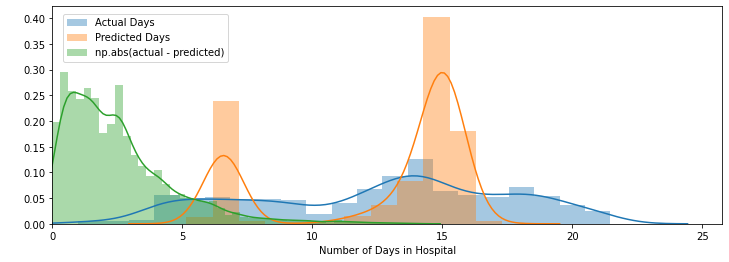

In [195]:
# With information leak

### Model

10,760 and 10,760 patients in train and test data sets, respectively.

Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 4.38529	valid_0's l2: 19.2307
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 4.38529	valid_0's l2: 19.2307


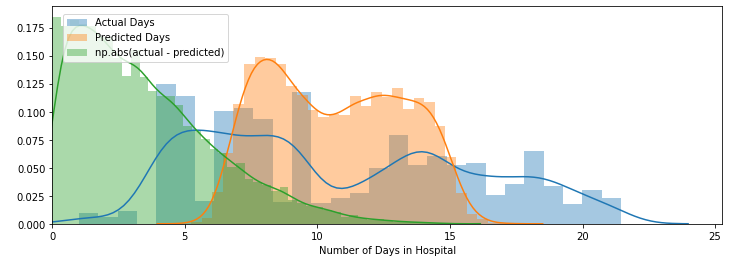

In [344]:
# features_n_hospitalized_truncated = list(get_feature_importance(
#     features_model_covid, 
#     model_n_hospitalized.feature_importances_, 
#     min_importance_threshold=10
# ).keys())

features_n_hospitalized_truncated = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Hyperlipidemia',
    'condition_chronic_Hypertension',
    'condition_chronic_Polyp of colon',
    'condition_recent_Polyp of colon',
    'encounters_Encounter for check up (procedure)',
    'encounters_Follow-up encounter',
    'encounters_General examination of patient (procedure)',
    'encounters_Periodic reevaluation and management of healthy individual (procedure)',
    'encounters_Urgent care clinic (procedure)',
    'medication_24 HR Metformin hydrochloride 500 MG Extended Release Oral Tablet',
    'medication_Hydrochlorothiazide 25 MG Oral Tablet',
    'medication_Simvastatin 10 MG Oral Tablet',
    'medication_insulin human  isophane 70 UNT/ML / Regular Insulin  Human 30 UNT/ML Injectable Suspension (Humulin)',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Glomerular filtration rate/1.73 sq M.predicted',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alanine aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Albumin (Mass/volume) in Serum or Plasma',
    'observation_Aspartate aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Erythrocytes (#/volume) in Blood by Automated count',
    'observation_Leukocytes (#/volume) in Blood by Automated count',
    'observation_MCH (Entitic mass) by Automated count',
    'observation_MCHC (Mass/volume) by Automated count',
    'observation_MCV (Entitic volume) by Automated count',
    'observation_Hemoglobin (Mass/volume) in Blood',
    'observation_Hematocrit (Volume Fraction) of Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood',
    'demographic_healthcare_expenses'
]

df_oversampled = df_input_model[
    lambda x: (
        (x[TARGET_COVID_DEATH] == 1) & \
        (x[TARGET_COVID] == 1) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0)
    )
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (
            (x[TARGET_COVID_DEATH] == 0) & \
            (x[TARGET_COVID] == 1) & \
            (x[TARGET_N_DAYS_HOSPITALIZED] > 0)
        )
    ].sample(int(n_rows_underrepresented*2), random_state=42),
    df_oversampled
], axis=0)

x_train_hospitalized, x_test_hospitalized, y_train_hospitalized, y_test_hospitalized = train_test_split(
    df_sampled[features_n_hospitalized_truncated],
    df_sampled[TARGET_N_DAYS_HOSPITALIZED],
    test_size=0.50,
    random_state=42
)

print(f'{x_train_hospitalized.shape[0]:,} and {x_test_hospitalized.shape[0]:,} ' + \
        'patients in train and test data sets, respectively.\n')

fit_params={
    'early_stopping_rounds': 5, 
}

model_n_hospitalized = lgb.LGBMRegressor()
model_n_hospitalized.fit(
    x_train_hospitalized, 
    y_train_hospitalized, 
    eval_set=[(x_test_hospitalized, y_test_hospitalized)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'predicted': model_n_hospitalized.predict(x_test_hospitalized),
    'actual': y_test_hospitalized
})

fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.distplot(df_predicted.actual, ax=ax, label='Actual Days')
sns.distplot(df_predicted.predicted, ax=ax, label='Predicted Days')
sns.distplot(np.abs(df_predicted.actual - df_predicted.predicted), ax=ax, label='np.abs(actual - predicted)')
ax.set_xlim(0)
ax.set_xlabel('Number of Days in Hospital')
fig.legend(bbox_to_anchor=(0.27, 0.88))

## Number of Days ICU

3,984 and 997 patients in train and test data sets, respectively.

[100]	valid_0's rmse: 2.52888	valid_0's l2: 6.39525


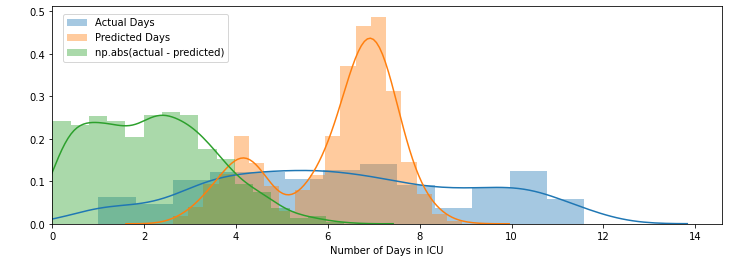

In [196]:
# With information leak

### Model

2,226 and 2,462 patients in train and test data sets, respectively.

Training until validation scores don't improve for 10 rounds
[100]	valid_0's rmse: 2.5302	valid_0's l2: 6.40189
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 2.52902	valid_0's l2: 6.39595


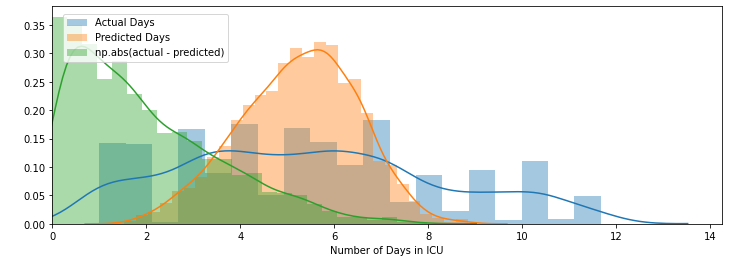

In [345]:
# features_n_icu = list(get_feature_importance(
#     features_model_covid, 
#     model_n_icu.feature_importances_, 
#     min_importance_threshold=10
# ).keys())

features_n_icu = [
    'demographic_county_residence',
    'demographic_age',
    'demographic_race',
    'demographic_gender',
    'demographic_healthcare_coverage',
    'condition_chronic_Body mass index 30+ - obesity (finding)',
    'condition_chronic_Prediabetes',
    'procedures_Medication Reconciliation (procedure)',
    'encounters_Encounter for check up (procedure)',
    'encounters_General examination of patient (procedure)',
    'encounters_Urgent care clinic (procedure)',
    'observation_Diastolic Blood Pressure',
    'observation_Systolic Blood Pressure',
    'observation_Protein (Mass/volume) in Serum or Plasma',
    'observation_Glomerular filtration rate/1.73 sq M.predicted',
    'observation_Bilirubin.total (Mass/volume) in Serum or Plasma',
    'observation_Alanine aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Alkaline phosphatase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Albumin (Mass/volume) in Serum or Plasma',
    'observation_Aspartate aminotransferase (Enzymatic activity/volume) in Serum or Plasma',
    'observation_Platelets (#/volume) in Blood by Automated count',
    'observation_Erythrocytes (#/volume) in Blood by Automated count',
    'observation_Leukocytes (#/volume) in Blood by Automated count',
    'observation_MCH (Entitic mass) by Automated count',
    'observation_MCHC (Mass/volume) by Automated count',
    'observation_MCV (Entitic volume) by Automated count',
    'observation_Hemoglobin (Mass/volume) in Blood',
    'observation_Hematocrit (Volume Fraction) of Blood by Automated count',
    'observation_Respiratory rate',
    'observation_Heart rate',
    'observation_Body Weight',
    'observation_Oxygen saturation in Arterial blood',
    'demographic_healthcare_expenses'
]

df_oversampled = df_input_model[
    lambda x: (
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_COVID] == 1) & \
        (x[TARGET_N_DAYS_ICU] > 0)
    )
]
n_rows_underrepresented = df_oversampled.shape[0]
df_oversampled = pd.concat([
    df_oversampled,
    df_oversampled,
], axis=0).reset_index(drop=True)
df_sampled = pd.concat([
    df_input_model[
        lambda x: (
            (x[TARGET_COVID_DEATH] == 1) & \
            (x[TARGET_COVID] == 1) & \
            (x[TARGET_N_DAYS_ICU] > 0)
        )
    ].sample(int(n_rows_underrepresented*2), random_state=42),
    df_oversampled
], axis=0)

x_train_icu, x_test_icu, y_train_icu, y_test_icu = train_test_split(
    df_sampled[features_n_icu],
    df_sampled[TARGET_N_DAYS_ICU],
    test_size=0.525,
    random_state=42
)

print(f'{x_train_icu.shape[0]:,} and {x_test_icu.shape[0]:,} ' + \
        'patients in train and test data sets, respectively.\n')

fit_params={
    'early_stopping_rounds': 10, 
}

model_n_icu = lgb.LGBMRegressor()
model_n_icu.fit(
    x_train_icu, 
    y_train_icu, 
    eval_set=[(x_test_icu, y_test_icu)], 
    eval_metric='rmse', 
    verbose=100,
    **fit_params
)

df_predicted = pd.DataFrame({
    'predicted': model_n_icu.predict(x_test_icu),
    'actual': y_test_icu
})

fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.distplot(df_predicted.actual, ax=ax, label='Actual Days')
sns.distplot(df_predicted.predicted, ax=ax, label='Predicted Days')
sns.distplot(np.abs(df_predicted.actual - df_predicted.predicted), ax=ax, label='np.abs(actual - predicted)')
ax.set_xlim(0)
ax.set_xlabel('Number of Days in ICU')
fig.legend(bbox_to_anchor=(0.27, 0.88))

# Analysis of Length of Stay (Hospitalization + ICU)

C:\Users\bduyp\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\bduyp\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\bduyp\Anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


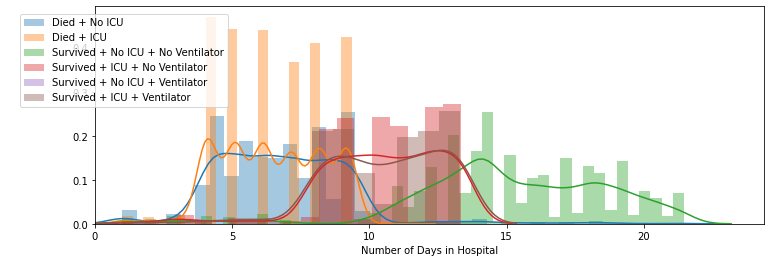

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 1) & \
        (x[TARGET_N_DAYS_ICU] == 0) 
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Died + No ICU')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 1) & \
        (x[TARGET_N_DAYS_ICU] > 0)
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Died + ICU')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] == 0) & \
        (x[TARGET_COVID_VENTILATED] == 0)
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Survived + No ICU + No Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 0)
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Survived + ICU + No Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] == 0) & \
        (x[TARGET_COVID_VENTILATED] == 1)
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Survived + No ICU + Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 1)
    )
][TARGET_N_DAYS_HOSPITALIZED], ax=ax, label='Survived + ICU + Ventilator')
ax.set_xlim(0)
ax.set_xlabel('Number of Days in Hospital')
fig.legend(bbox_to_anchor=(0.27, 0.88))

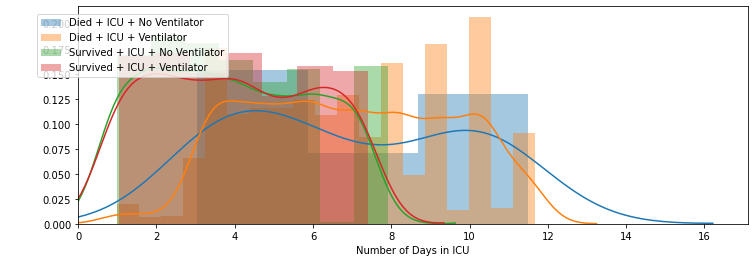

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 1) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 0)
    )
][TARGET_N_DAYS_ICU], ax=ax, label='Died + ICU + No Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 1) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 1)
    )
][TARGET_N_DAYS_ICU], ax=ax, label='Died + ICU + Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 0)
    )
][TARGET_N_DAYS_ICU], ax=ax, label='Survived + ICU + No Ventilator')
sns.distplot(df_input_model[
    lambda x: (
        (x[TARGET_COVID] == TARGET_VARIABLE_COVID_POSITIVE) & \
        (x[TARGET_N_DAYS_HOSPITALIZED] > 0) & \
        (x[TARGET_COVID_DEATH] == 0) & \
        (x[TARGET_N_DAYS_ICU] > 0) & \
        (x[TARGET_COVID_VENTILATED] == 1)
    )
][TARGET_N_DAYS_ICU], ax=ax, label='Survived + ICU + Ventilator')
ax.set_xlim(0)
ax.set_xlabel('Number of Days in ICU')
fig.legend(bbox_to_anchor=(0.27, 0.88))

# Generate predictions on testing data and export

In [369]:
df_testing = df_input_model[
    lambda x: x.is_testing_data == 0
].copy()

In [371]:
df_testing.shape

(29492, 686)

In [404]:
df_predicted = pd.DataFrame({
    'id': df_testing.id,
    'predicted_covid': model_covid.predict_proba(df_testing[features_covid_truncated])[:, 1],
    'predicted_death': model_death.predict_proba(df_testing[features_death_truncated])[:, 1],
    'predicted_ventilated': model_ventilated.predict_proba(df_testing[features_ventilated_truncated])[:, 1],
    'predicted_hospitalized_likelihood': model_hospitalized.predict_proba(df_testing[features_hospitalized_truncated])[:, 1],
    'predicted_icu_likelihood': model_icu.predict_proba(df_testing[features_icu_truncated])[:, 1],
    'predicted_n_hospitalized': model_n_hospitalized.predict(df_testing[features_n_hospitalized_truncated]),
    'predicted_n_icu': model_n_icu.predict(df_testing[features_n_icu]),
})
df_predicted['predicted_alive'] = 1 - df_predicted['predicted_death']

# COVID status cut-offs
df_predicted.loc[
    lambda x: x.predicted_covid < 0.5,
    'predicted_alive' 
] = 1
df_predicted.loc[
    lambda x: x.predicted_covid < 0.5,
    'predicted_ventilated' 
] = 0
df_predicted.loc[
    lambda x: x.predicted_covid < 0.5,
    'predicted_n_icu' 
] = 0
df_predicted.loc[
    lambda x: x.predicted_covid < 0.5,
    'predicted_n_hospitalized' 
] = 0

# ICU + Hospitalization Likelihood on Length of Stay cut-offs
df_predicted.loc[
    lambda x: x.predicted_hospitalized_likelihood < 0.2,
    'predicted_n_hospitalized' 
] = 0
df_predicted.loc[
    lambda x: x.predicted_icu_likelihood < 0.2,
    'predicted_n_icu' 
] = 0

# Export files
df_predicted[['id','predicted_covid']].to_csv('export_covid.csv', header=False, index=False, line_terminator='\n')
df_predicted[['id','predicted_alive']].to_csv('export_alive.csv', header=False, index=False, line_terminator='\n')
df_predicted[['id','predicted_ventilated']].to_csv('export_ventilated.csv', header=False, index=False, line_terminator='\n')
df_predicted[['id','predicted_n_icu']].to_csv('export_n_icu.csv', header=False, index=False, line_terminator='\n')
df_predicted[['id','predicted_n_hospitalized']].to_csv('export_n_hospitalized.csv', header=False, index=False, line_terminator='\n')

display(df_predicted.head())

,id,predicted_covid,predicted_death,predicted_ventilated,predicted_hospitalized_likelihood,predicted_icu_likelihood,predicted_n_hospitalized,predicted_n_icu,predicted_alive
75418,8c6f61a6-1beb-4b51-980e-381722ca7e33,0.876215,0.022072,0.021323,0.003981,0.008370,0.0,0.000000,0.977928
75420,6732e6fc-f8f3-4b1a-924a-47f68f19526c,0.648990,0.007067,0.003633,0.004841,0.005632,0.0,0.000000,0.992933
75422,4772a573-1fb1-49ec-be86-dc2c4b176052,0.999499,0.065157,0.015939,0.009201,0.365360,0.0,6.240368,0.934843
75424,edb75aa7-7b67-48ce-9990-0095cd7a3b8d,0.578143,0.078118,0.095171,0.007440,0.045159,0.0,0.000000,0.921882
75426,e28f36cd-c8d8-4c64-94e7-91c89d1be9d1,0.999739,0.042466,0.056645,0.012200,0.014440,0.0,0.000000,0.957534


# Analysis of Risk and Protective Factors

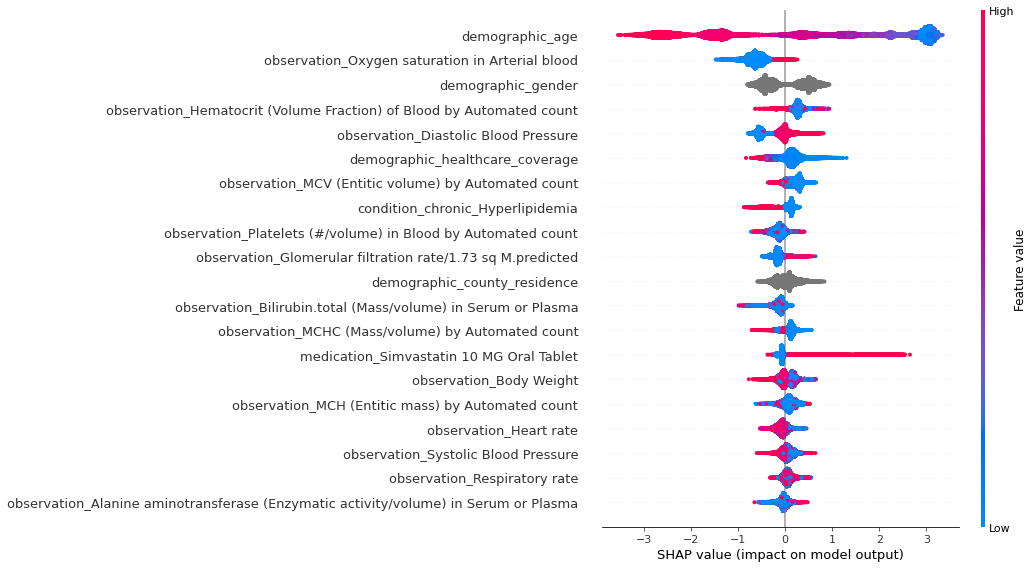

In [400]:
import shap

x = df_testing[features_n_hospitalized_truncated]
shap_values = shap.TreeExplainer(model_n_hospitalized).shap_values(x)
shap.summary_plot(shap_values, x)

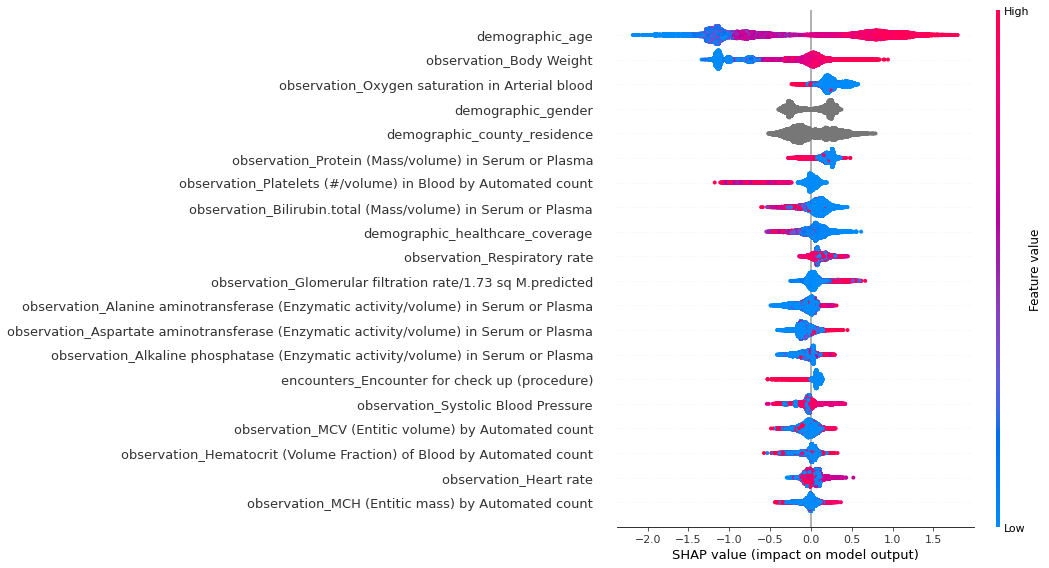

In [401]:
x = df_testing[features_n_icu]
shap_values = shap.TreeExplainer(model_n_icu).shap_values(x)
shap.summary_plot(shap_values, x)